Steps:

1. Add column with entry Abortion, Prolife, Prochoice for each dataframe based on hashtag that was used to scrape data
2. Append all three dataframes
3. Remove duplicate rows based on tweet ids. Some tweets will contain all three hashtags 
4. Extract hashtags from each tweet and count the most frequently occurring hashtags
5. Remove twitter handles
6. Clean tweets - tweet-preprocessor
7. Remove punctuations, stopwords, digits - package NLKT
8. Remove short words e.g. ummm, oh etc (?)
9. HTML decoding?
10. UTF-8 BOM?
11. Lemmatization
12. Tokenization


Sentiment Analysis:
1. Text Classification
2. Linguistic classification
    -Vader



References:
1. Cleaning: 
    - https://www.kaggle.com/ragnisah/text-data-cleaning-tweets-analysis
    - https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
    - https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90
    - https://www.kaggle.com/sreejiths0/efficient-tweet-preprocessing
    - https://www.kaggle.com/amar09/sentiment-analysis-on-scrapped-tweets
    - https://medium.com/analytics-vidhya/pre-processing-tweets-for-sentiment-analysis-a74deda9993e
    - https://stackoverflow.com/questions/50830214/remove-usernames-from-twitter-data-using-python
    - Remove '&amp' etc: https://stackoverflow.com/questions/2360598/how-do-i-unescape-html-entities-in-a-string-in-python-3-1
    - https://docs.python.org/3/library/string.html
    - https://stackoverflow.com/questions/39782418/remove-punctuations-in-pandas
    - https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html
    - https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
    
2. Hashtag extraction: 
    - https://stackoverflow.com/questions/2527892/parsing-a-tweet-to-extract-hashtags-into-an-array
    - https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e
    
3. Sentiment Analysis
    - https://nealcaren.org/lessons/wordlists/
    - https://repository.kaust.edu.sa/bitstream/handle/10754/623027/Sentiment-Analysis.pdf;jsessionid=1EE9754F4AA19D9011BD891FE78E337D?sequence=1
    - https://stanfordnlp.github.io/stanza/
    - https://www.infoworld.com/article/3519413/8-great-python-libraries-for-natural-language-processing.html
   

Notes:

Error in importing file "tweets_prochoice.csv", resolved:
- https://stackoverflow.com/questions/33998740/error-in-reading-a-csv-file-in-pandascparsererror-error-tokenizing-data-c-err
- https://www.programiz.com/python-programming/writing-csv-files

Additionally, using lineterminator in code, to avoid tweets from splitting.

Preprocessing
1. BeautifulSoup(text1, 'lxml') did not work to decode html
2. Perform sanity checks on processed data: https://stackoverflow.com/questions/56191994/how-to-search-for-a-word-in-a-column-with-pandas

In [100]:
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import html
import preprocessor as pp
import string
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from nltk.probability import FreqDist

from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/manasip/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/manasip/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Import dataframes for tweets with hashtags: abortion, prochoice, prolife and add columns with noisy labels

In [101]:
df_abortion = pd.read_csv("tweets.csv", lineterminator='\n', encoding='utf-8')
df_abortion["noisy"] = "abortion"
print(df_abortion.shape)
df_abortion.head()

(200748, 5)


,Datetime,Tweet Id,Text,Username,noisy
0,2017-12-30 23:53:15+00:00,947254285393432578,@glamourmag explores how #American #Television...,Dhammikax,abortion
1,2017-12-30 23:52:17+00:00,947254040840241152,Top US #healthcare stories 2017 from @TheHill ...,JohnJSeng,abortion
2,2017-12-30 23:28:30+00:00,947248058668060672,"@PPIndKentucky recently tweeted ""my body, my c...",StockelmanT,abortion
3,2017-12-30 23:27:18+00:00,947247754748874752,Abortion and Women's Health \n#Abortion #Proli...,spucscotland,abortion
4,2017-12-30 23:13:16+00:00,947244225053290502,Looking at How #Abortion Restrictions Endanger...,ccaa,abortion


In [102]:
df_abortion["Tweet Id"].nunique() #check if file is populated correctly

200748

In [103]:
df_prochoice = pd.read_csv("tweets_prochoice.csv", lineterminator='\n', encoding='utf-8')
df_prochoice["noisy"] = "prochoice"
print(df_prochoice.shape)
df_prochoice.head()

(70627, 5)


,Datetime,Tweet Id,Text,Username,noisy
0,2017-12-30 23:05:07+00:00,947242172960690176,"@Ciaran_31 Easy, they can be incinerated to he...",EmmaMurphy12150,prochoice
1,2017-12-30 23:01:26+00:00,947241245163884544,Epi 18 of #Sexology #podcast | Myths &amp; Mis...,oasis2care,prochoice
2,2017-12-30 22:58:37+00:00,947240535424684033,"@DavQuinn The term ""pro-choice"" will be rememb...",Christendom_IE,prochoice
3,2017-12-30 22:47:34+00:00,947237754940792832,@JamesHasson20 @politicalelle @hale_razor We m...,ProudLiberal11,prochoice
4,2017-12-30 22:40:51+00:00,947236067534622721,Hell Yes! #ProChoice https://t.co/ovxbZ3gZY3,rescino_lynn,prochoice


In [104]:
df_prochoice["Tweet Id"].nunique() #check if file is populated correctly

70627

In [105]:
df_prolife = pd.read_csv("tweets_prolife.csv", lineterminator='\n', encoding='utf-8')
df_prolife["noisy"] = "prolife"
print(df_prolife.shape)
df_prolife.head()

(309329, 5)


,Datetime,Tweet Id,Text,Username,noisy
0,2017-12-30 23:56:47+00:00,947255176401969152,@LilaGraceRose This is fantastic! Those baby s...,ThomasKraly,prolife
1,2017-12-30 23:55:18+00:00,947254802391752704,Excellent news! Now we just need the others to...,ThomasKraly,prolife
2,2017-12-30 23:51:24+00:00,947253819163009024,These are the pro-life stories that touched ou...,CruzinAhead,prolife
3,2017-12-30 23:30:15+00:00,947248498575110144,It would be easy to focus on the hardships the...,TheSparrowNest,prolife
4,2017-12-30 23:30:13+00:00,947248487380520960,"As advocates for life, it's important that we ...",Anglicans4Life,prolife


In [106]:
df_prolife["Tweet Id"].nunique() #check if file is populated correctly

309329

In [107]:
#Rename column names
df_abortion.rename(columns={"Tweet Id": "id", "Datetime": "date", "Text": "tweet", "Username": "user"}, \
                   inplace=True)
df_prochoice.rename(columns={"Tweet Id": "id", "Datetime": "date", "Text": "tweet", "Username": "user"}, \
                    inplace=True)
df_prolife.rename(columns={"Tweet Id": "id", "Datetime": "date", "Text": "tweet", "Username": "user"}, \
                  inplace=True)

In [108]:
#Append Dataframe. Some tweets will have both or all 3 tweets. We remove these

In [109]:
df = pd.DataFrame(columns=df_abortion.columns)

In [110]:
df = df.append(df_abortion, ignore_index=True)

In [111]:
df = df.append(df_prochoice, ignore_index=True)

In [112]:
print(df.shape[0], df_abortion.shape[0] + df_prochoice.shape[0]) 

271375 271375


In [113]:
##Remove duplicates

In [114]:
df.id.nunique()

256051

We can see that there is not much overlap between #abortion and #prochoice

In [115]:
df.drop_duplicates(subset=['id'], inplace=True)

In [116]:
append1 = df.shape #verify that we have all unique values
print(append1)

(256051, 5)


In [117]:
df = df.append(df_prolife, ignore_index=True)

In [118]:
print(df.shape[0], append1[0] + df_prolife.shape[0])#Check if append worked
print(df.index.max())

565380 565380
565379


In [119]:
##Remove duplicates

In [120]:
df.id.nunique()

531646

Again approx overlap of 30k tweet between #abortion, #prochoice, #prolife

In [121]:
df.drop_duplicates(subset=['id'], inplace=True)

In [122]:
append2 = df.shape #verify that we have all unique values
print(append2)

(531646, 5)


In [123]:
df.head()

,date,id,tweet,user,noisy
0,2017-12-30 23:53:15+00:00,947254285393432578,@glamourmag explores how #American #Television...,Dhammikax,abortion
1,2017-12-30 23:52:17+00:00,947254040840241152,Top US #healthcare stories 2017 from @TheHill ...,JohnJSeng,abortion
2,2017-12-30 23:28:30+00:00,947248058668060672,"@PPIndKentucky recently tweeted ""my body, my c...",StockelmanT,abortion
3,2017-12-30 23:27:18+00:00,947247754748874752,Abortion and Women's Health \n#Abortion #Proli...,spucscotland,abortion
4,2017-12-30 23:13:16+00:00,947244225053290502,Looking at How #Abortion Restrictions Endanger...,ccaa,abortion


-----------------------------------
TASK 2 - Descriptive Stats
----------------------------------

In [124]:
#Extract Hashtags from tweets

In [125]:
#df['test_tweet'] = df['Text']

In [126]:
df.head()

,date,id,tweet,user,noisy
0,2017-12-30 23:53:15+00:00,947254285393432578,@glamourmag explores how #American #Television...,Dhammikax,abortion
1,2017-12-30 23:52:17+00:00,947254040840241152,Top US #healthcare stories 2017 from @TheHill ...,JohnJSeng,abortion
2,2017-12-30 23:28:30+00:00,947248058668060672,"@PPIndKentucky recently tweeted ""my body, my c...",StockelmanT,abortion
3,2017-12-30 23:27:18+00:00,947247754748874752,Abortion and Women's Health \n#Abortion #Proli...,spucscotland,abortion
4,2017-12-30 23:13:16+00:00,947244225053290502,Looking at How #Abortion Restrictions Endanger...,ccaa,abortion


In [127]:
df['hashtags'] = df.tweet.apply(lambda x: re.findall(r"#(\w+)", x)) 
## Check what segmented hashtags are and why you should ekphrasis to get around it

In [128]:
### Get top 15 hashtags

In [129]:
hashtag_series = df.hashtags

In [130]:
hashtag_series = hashtag_series.apply(pd.Series).stack().reset_index(drop=True)

In [131]:
hashtag_series = hashtag_series.str.lower()

In [132]:
df_hashtag = hashtag_series.value_counts().to_frame().rename(columns={0: "Count"})

In [133]:
df_hashtag[:15]

,Count
prolife,310724
abortion,201742
prochoice,70814
pjnet,64856
unbornlivesmatter,55424
defundpp,23399
uniteblue,15953
tcot,15075
praytoendabortion,14939
ccot,13334


Notice in the above table how most of the top hashtags are anti abortion

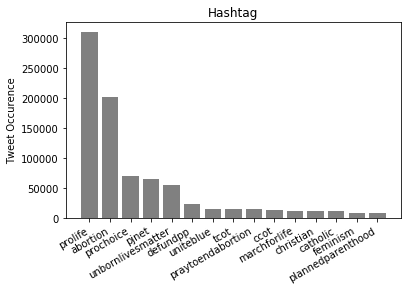

In [134]:
fig, ax = plt.subplots()

ax.bar(df_hashtag[:15].index, df_hashtag[:15].Count, \
       align="center", \
      color="grey")

plt.ylabel('Tweet Occurence')
plt.title('Hashtag')
fig.autofmt_xdate()

plt.show()

In [32]:
#User statistics

In [135]:
df.user.nunique()

88467

In [136]:
df.user.value_counts().mean()

6.009540280556592

In [137]:
df.user.value_counts().std()

94.43761625461623

-----------------------------------
TASK 3 - Preprocessing Data
----------------------------------

1. re.sub('@[^\s]+','',Tweet)
2. df['Great'] = df["Summary"].str.contains("great", case=False, na=False).astype(int) - check text processing
https://stackoverflow.com/questions/32398024/read-tweets-extracted-with-python - try encoding when reading file
3. Did basic sanity checks to detect presence of UTF-BOM characters. None found.
4. Replace '\n', '\r' with "" at some point - https://stackoverflow.com/questions/16566268/remove-all-line-breaks-from-a-long-string-of-text
5. These did not work for punctuations: df.clean_tweet = df.clean_tweet.apply(lambda x: x.replace('[{}]'.format(string.punctuation), '')) ----- str.replace('[{}]'.format(string.punctuation), '') ----df.clean_tweet = df.clean_tweet.apply(lambda x: x.replace('[^\w\s]',''))

In [138]:
df.head()

,date,id,tweet,user,noisy,hashtags
0,2017-12-30 23:53:15+00:00,947254285393432578,@glamourmag explores how #American #Television...,Dhammikax,abortion,"[American, Television, Abortion, audience, evi..."
1,2017-12-30 23:52:17+00:00,947254040840241152,Top US #healthcare stories 2017 from @TheHill ...,JohnJSeng,abortion,"[healthcare, obamacare, opioidepidemic, aborti..."
2,2017-12-30 23:28:30+00:00,947248058668060672,"@PPIndKentucky recently tweeted ""my body, my c...",StockelmanT,abortion,"[abortion, ProLife, PlannedParenthood, DefundPP]"
3,2017-12-30 23:27:18+00:00,947247754748874752,Abortion and Women's Health \n#Abortion #Proli...,spucscotland,abortion,"[Abortion, Prolife]"
4,2017-12-30 23:13:16+00:00,947244225053290502,Looking at How #Abortion Restrictions Endanger...,ccaa,abortion,"[Abortion, SRHR]"


In [139]:
df["clean_tweet"] = df.tweet

In [140]:
#Step 1: Decode html escape characters: &amp &quote etc - should remove these altogether?
#df.test2 = df.test2.apply(lambda x: html.unescape(x))
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub(r'&[a-z]+;', '', x))

In [141]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("&", case=False, na=False).astype(int) # Checked for &gt, &amp &#62 &quote
print(sum(df.check))

0


In [142]:
#Step 2: Remove @mentions
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub('@[^\s]+','',x))
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub('@[^\w]+','',x))
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub('@','',x))

In [143]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("@", case=False, na=False).astype(int) 
print(sum(df.check))

0


In [144]:
#Step 3 Remove \n \t \r
df.clean_tweet = df.clean_tweet.apply(lambda x: x.replace('\n', '').replace('\t', '').replace('\r', ''))

In [145]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("\n", case=False, na=False).astype(int) 
print('n', sum(df.check))

df['check'] = df.clean_tweet.str.contains("\t", case=False, na=False).astype(int) 
print('t', sum(df.check))

df['check'] = df.clean_tweet.str.contains("\r", case=False, na=False).astype(int) 
print('r', sum(df.check))

n 0
t 0
r 0


In [146]:
#Step 4: Tweet-preprocessor to remove, urls, emojis, hashtags, reserved words, mentions (if any), smileys
df.clean_tweet = df.clean_tweet.apply(lambda x: pp.clean(x))

In [147]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("#", case=False, na=False).astype(int) 
print("check #",sum(df.check))
df['check'] = df.clean_tweet.str.contains("http", case=False, na=False).astype(int) 
print("check http",sum(df.check))
df['check'] = df.clean_tweet.str.contains("http", case=False, na=False).astype(int) 
print("check www",sum(df.check))

check # 0
check http 29
check www 29


----Ignore the 29 tweet for now----

In [387]:
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub(r"https\:[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub(r"http\:[a-z]?\.?(com)+|[a-z]+\.(com)", '', x))
#did not work

In [148]:
#Step 5: Remove Placeholders
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub(r'{link}', '', x))
df.clean_tweet = df.clean_tweet.apply(lambda x: re.sub(r"\[video\]", '', x))

In [149]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("{link}", case=False, na=False).astype(int) 
print("check link",sum(df.check))
df['check'] = df.clean_tweet.str.contains("\[video\]", case=False, na=False).astype(int) 
print("check video",sum(df.check))

check link 0
check video 187


----Ignore the 187 tweet for now----

In [150]:
#Step 6: Remove punctuations, digits
#Create helper function
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

def remove_digits(text):
    for digit in string.digits:
        text = text.replace(digit, '')
    return text

df.clean_tweet = df.clean_tweet.apply(remove_punctuations)

df.clean_tweet = df.clean_tweet.apply(remove_digits)

In [151]:
#Sanity check
df['check'] = df.clean_tweet.str.contains("\!", case=False, na=False).astype(int)
print("check !",sum(df.check))
df['check'] = df.clean_tweet.str.contains("\?", case=False, na=False).astype(int)
print("check ?",sum(df.check))
df['check'] = df.clean_tweet.str.contains("\.", case=False, na=False).astype(int)
print("check .",sum(df.check))

df['check'] = df.clean_tweet.str.contains("1", case=False, na=False).astype(int)
print("check 1",sum(df.check))

check ! 0
check ? 0
check . 0
check 1 0


In [152]:
#Step 7 Lowercase before tokenization
df.clean_tweet = df.clean_tweet.str.lower()

In [153]:
#Step 7 Tokenization
tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)

In [154]:
df["tok_tweet"] = df.clean_tweet.apply(lambda x: tknzr.tokenize(x))

Note to self - Lower case before applying stopwords

In [155]:
#Step 8 Remove stopwords 
#Create helper function

stopword = nltk.corpus.stopwords.words('english')

def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text

df.tok_tweet = df.tok_tweet.apply(lambda x: remove_stopwords(x))

In [94]:
"The" in stopword #delete this

False

In [53]:
#Step 9 Stemming - delete this
#Create helper function

sm = nltk.PorterStemmer() #not great

def stem(text):
    text = [sm.stem(word) for word in text]
    return text

df.tok_tweet = df.tok_tweet.apply(lambda x: stem(x))

In [433]:
#Step 9 Stemming - delete this
#Create helper function

snow = nltk.stem.SnowballStemmer('english') #okayish
def stem(text):
    text = [snow.stem(word) for word in text]
    return text

df.tok_tweet = df.tok_tweet.apply(lambda x: stem(x))

--- Neither stemmer seems better than the other ---

In [156]:
#Step 9 Lemmatization
#Create helper function

lem = nltk.WordNetLemmatizer()

def lemmat(text):
    text = [lem.lemmatize(word) for word in text]
    return text

df.tok_tweet = df.tok_tweet.apply(lambda x: lemmat(x))

--- Use lemmatization instead of stemmer ----

In [157]:
df.head()

,date,id,tweet,user,noisy,hashtags,clean_tweet,check,tok_tweet
0,2017-12-30 23:53:15+00:00,947254285393432578,@glamourmag explores how #American #Television...,Dhammikax,abortion,"[American, Television, Abortion, audience, evi...",explores how covers for an ever devided we mu...,0,"[explores, cover, ever, devided, must, ask, ca..."
1,2017-12-30 23:52:17+00:00,947254040840241152,Top US #healthcare stories 2017 from @TheHill ...,JohnJSeng,abortion,"[healthcare, obamacare, opioidepidemic, aborti...",top us stories from pushback on by access,0,"[top, u, story, pushback, access]"
2,2017-12-30 23:28:30+00:00,947248058668060672,"@PPIndKentucky recently tweeted ""my body, my c...",StockelmanT,abortion,"[abortion, ProLife, PlannedParenthood, DefundPP]",recently tweeted my body my choice repeatedly ...,0,"[recently, tweeted, body, choice, repeatedly, ..."
3,2017-12-30 23:27:18+00:00,947247754748874752,Abortion and Women's Health \n#Abortion #Proli...,spucscotland,abortion,"[Abortion, Prolife]",abortion and womens health,0,"[abortion, woman, health]"
4,2017-12-30 23:13:16+00:00,947244225053290502,Looking at How #Abortion Restrictions Endanger...,ccaa,abortion,"[Abortion, SRHR]",looking at how restrictions endanger womens lives,0,"[looking, restriction, endanger, woman, life]"


In [158]:
##Create word cloud

df["cloud"] = df.tok_tweet.apply(lambda x: ' '.join([str(elem) for elem in x]))

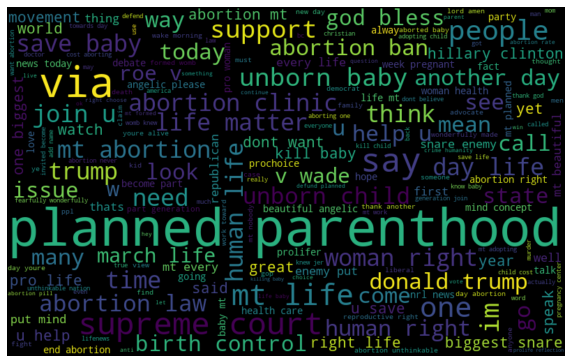

In [159]:
all_words = ' '.join([text for text in df.cloud])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [160]:
df.head()

,date,id,tweet,user,noisy,hashtags,clean_tweet,check,tok_tweet,cloud
0,2017-12-30 23:53:15+00:00,947254285393432578,@glamourmag explores how #American #Television...,Dhammikax,abortion,"[American, Television, Abortion, audience, evi...",explores how covers for an ever devided we mu...,0,"[explores, cover, ever, devided, must, ask, ca...",explores cover ever devided must ask cannot dr...
1,2017-12-30 23:52:17+00:00,947254040840241152,Top US #healthcare stories 2017 from @TheHill ...,JohnJSeng,abortion,"[healthcare, obamacare, opioidepidemic, aborti...",top us stories from pushback on by access,0,"[top, u, story, pushback, access]",top u story pushback access
2,2017-12-30 23:28:30+00:00,947248058668060672,"@PPIndKentucky recently tweeted ""my body, my c...",StockelmanT,abortion,"[abortion, ProLife, PlannedParenthood, DefundPP]",recently tweeted my body my choice repeatedly ...,0,"[recently, tweeted, body, choice, repeatedly, ...",recently tweeted body choice repeatedly believ...
3,2017-12-30 23:27:18+00:00,947247754748874752,Abortion and Women's Health \n#Abortion #Proli...,spucscotland,abortion,"[Abortion, Prolife]",abortion and womens health,0,"[abortion, woman, health]",abortion woman health
4,2017-12-30 23:13:16+00:00,947244225053290502,Looking at How #Abortion Restrictions Endanger...,ccaa,abortion,"[Abortion, SRHR]",looking at how restrictions endanger womens lives,0,"[looking, restriction, endanger, woman, life]",looking restriction endanger woman life


In [61]:
###Tweet word distribution

In [161]:
#Create a list of all words
all_words = [word for tokens in df.tok_tweet for word in tokens]

In [162]:
#Create a list of tweet length
tweet_lengths = [len(tokens) for tokens in df.tok_tweet]

In [163]:
vocab = sorted(list(set(all_words)))

print('{} tokens total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

3660043 tokens total, with a vocabulary size of 81699
Max tweet length is 35


In [164]:
#Average word size
word_length = []
for word in all_words:
    word_length.append(len(word))

In [165]:
print('average word size is {}'.format( sum(word_length) / len(word_length)))

average word size is 5.78256840151878


/Users/manasip/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


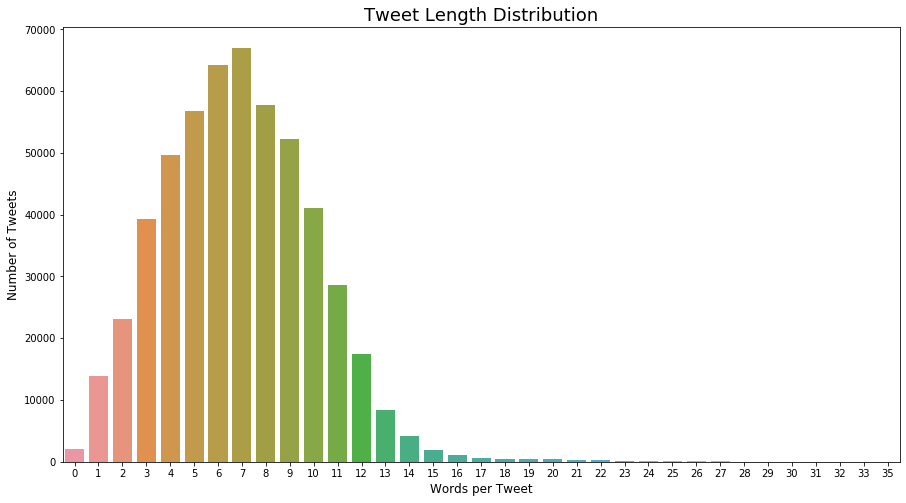

In [166]:
#Plotting tweet length distribution
plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

In [72]:
#Removing all tweets with less than 3 words

In [167]:
less_than_3_tokens = df[df.tok_tweet.apply(lambda x: len(x) <= 3)].index

In [168]:
df.drop(less_than_3_tokens, inplace = True)

In [169]:
df.reset_index(inplace=True)

In [170]:
#Redo above exercise

all_words = [word for tokens in df.tok_tweet for word in tokens]
tweet_lengths = [len(tokens) for tokens in df.tok_tweet]
vocab = sorted(list(set(all_words)))

print('{} tokens total, with a vocabulary size of {}'.format(len(all_words), len(vocab)))
print('Max tweet length is {}'.format(max(tweet_lengths)))

3482105 tokens total, with a vocabulary size of 79065
Max tweet length is 35


/Users/manasip/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


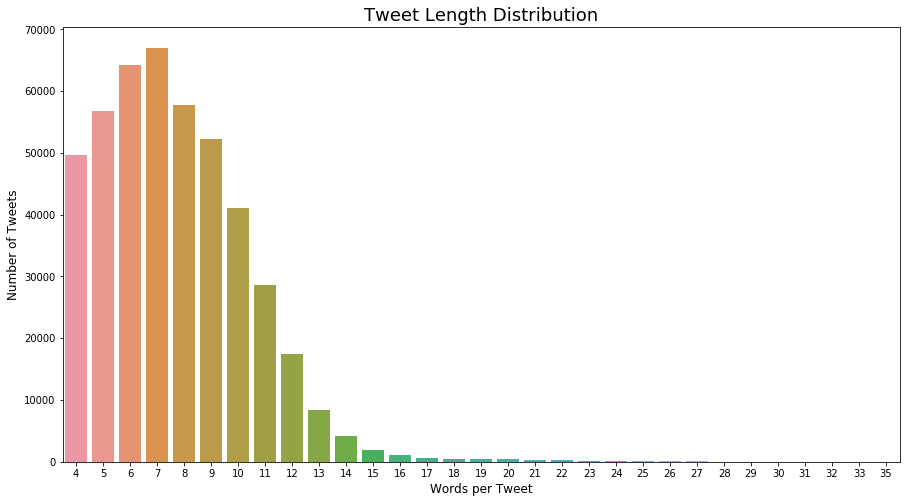

In [171]:
#Plotting tweet length distribution
plt.figure(figsize = (15,8))
sns.countplot(tweet_lengths)
plt.title('Tweet Length Distribution', fontsize = 18)
plt.xlabel('Words per Tweet', fontsize = 12)
plt.ylabel('Number of Tweets', fontsize = 12)
plt.show()

In [172]:
#Pointless use all words #Delete this
flat_words = [item for sublist in df.tok_tweet for item in sublist]

In [83]:
flat_words==all_words #Sanity check delete this

True

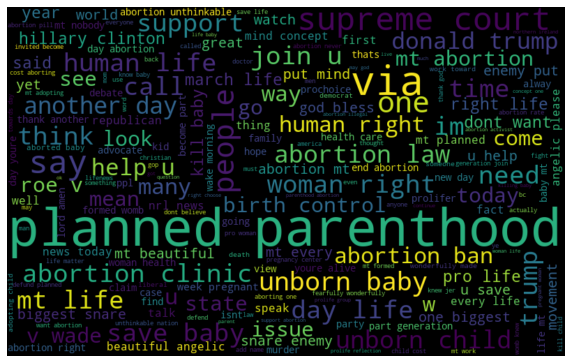

In [173]:
##Create word cloud
df["cloud2"] = df.tok_tweet.apply(lambda x: ' '.join([str(elem) for elem in x]))
all_words2 = ' '.join([text for text in df.cloud2])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words2)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [174]:
word_freq = FreqDist(flat_words)

In [175]:
word_freq.most_common(25)

[('abortion', 85251),
 ('woman', 49242),
 ('life', 45800),
 ('mt', 42213),
 ('baby', 36181),
 ('right', 27477),
 ('u', 21681),
 ('child', 20368),
 ('planned', 17112),
 ('via', 16851),
 ('parenthood', 15809),
 ('law', 15544),
 ('prolife', 15241),
 ('one', 15180),
 ('god', 14831),
 ('dont', 14772),
 ('new', 14193),
 ('support', 13219),
 ('want', 13032),
 ('day', 12694),
 ('people', 12557),
 ('trump', 12185),
 ('today', 11841),
 ('bill', 11796),
 ('human', 11337)]

###Plot of most common words##

In [176]:
#retrieve word and count from FreqDist tuples

most_common_count = [x[1] for x in word_freq.most_common(100)]
most_common_word = [x[0] for x in word_freq.most_common(100)]

#create dictionary mapping of word count
top_100 = dict(zip(most_common_word, most_common_count))

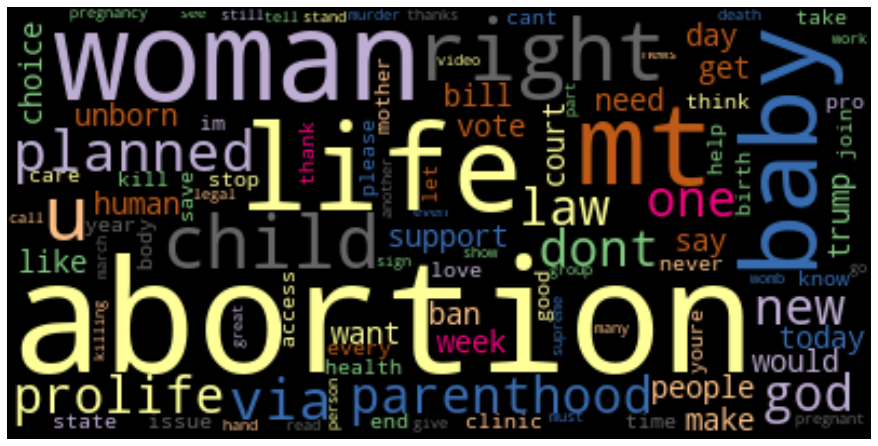

In [177]:
#Create Word Cloud of top 30 words
wordcloud = WordCloud(colormap = 'Accent', background_color = 'black')\
.generate_from_frequencies(top_100)

#plot with matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.savefig('top_30_cloud.png')


plt.show()